# Domain Specific Code Generation using the FormLang DSL

## Abstract

AI and LLM systems are being trained to perform a variety of complex tasks requiring expertise in many software tools, languages and technology stacks. Some of the challenges in this process involve quality data acquisition in large amounts, handling the increase of model parameter count which leads to increasing compute demands and costs, as well as emerging Data Privacy and Intellctual Property concerns related with using 3rd party cloud services for model training.

In this work we attempt to harness and combine the benefits of Abstraction and Determinism provided by Formal Domain Specific Languages (DSLs) with the innate ability of LLMs to learn new languages and their semantics. We propose a novel generation task called "Domain Specific Code Generation" which involve mapping user requests written in natural language to DSL code.

By utilizing a specially crafted DSL called `FormLang` as a case study, we attempt to lay the groundwork for methods of automated DSL dataset generation, training techniques and performance evaluation, with the end goal of creating an AI system capable of generating Web forms according to a user request. If successful and viable, these methods can be applied to other problem domains in which real-world processes can be formally modelled using DSLs, opening the door to the training of AI agents that understand these DSLs and can be engineered to perform tasks autonomously.

Our `FormLang` DSL allows expressing the semantics of Web-forms using a simplified syntax that does not require much, if any, Web-programming knowledge and expertise.

Given a user prompt in English describing the desired form and its fields the LLM produces syntactically valid `FormLang` output which is run through the accompanying FormLang parser and a hand-crafted React JSX compiler to output a final implementation of the form in JavaScript and React.


## Referring to this work

If you use this work the following quote is preferred:

```bibtex
@misc{guyor2025dscodegenformlang,
      title={Domain Specific Code Generation using the FormLang DSL},
      author={Guy Or},
      year={2025}
}
```

The official repository of this work is hosted in GitHub at https://github.com/guyo13/Form-Lang.

## Project Goals

* Create an AI training pipeline for FormLang (implemented as a Juypter notebook) which includes:
    * Automatic FormLang Dataset generation using searching algorithms and heuristics.
    * Baseline model selection and loading from Hugging Face.
    * Dataset Preprocessing and loading.
    * Defining performance metrics for the model.
    * Model fine tuning using Transformers library
    * Model Adapter training using PEFT library.
    * Model upload to Hugging Face Hub and example usage from the Hub.
    *  **(TBD)** Export to ONNX using Optimum and run on-device using Transformers.js.
* Create the “FormLang” language:
    * Describe the problem domain.
    * Defining a viable minimal syntax and semantics which are research focused rather than completeness focused.
    *  **(TBD)** Implementing a “JavaScript React” compile target.
*  **(TBD)** Create a live demo website:
    * **(TBD)** Users input a prompt.
    * **(TBD)** A FormLang editor is populated with the AI’s code generation results.
    * **(TBD)** The form is rendered alongside the generated code.
*  Discuss the project results:
    * Perfornace and user acceptability.
    * **(TBD)** Viability of the implemented methods for the Domain Specific Code Generation task and generalization to other domains.  
    * **(TBD)** Potential enhancements to the system.
    * **(TBD)** Possible research directions on how to learn from user data.


**(TBD)** - Features marked as TBD are depending on the project's progress and timeline constraints as well as proving the viability of the methods and system.

# Dataset generation

## Generating the dataset

The `ProbabilisticSearchFormGenerator` is class implemeting a parameterized algorithm for randomly generating forms:

* Iterate Depth-First, start with an empty form definition.
* For each item off the frontier if the item is a Field, append it to its Parent Form.
* If the item is a Form, generate its children and add them onto the frontier. Generate children according to the following rules:
    * Assign to the child node $depth = parentDepth + 1$.
    * There is a probability of $\alpha^{d}$ of generating a random child Form where $0 \leq \alpha < 1$ and $d$ is the depth of the child.
    * There is an optional parameter $D$ for defining the maximum depth for nested forms, which sets to $0$ the probability to generate a nested Form if its depth will be $D$.
    * There is a probability of $1 - \alpha^{d}$ of generating a random child Field.
    * The number of generated children is a random number in the range of $[0, maxChildren]$.
    * There is a probability of $\beta$ that a generated Field will contain a `state`.
      * There is a probability of $\gamma$ that a state definition will be an `array`.
        * The number of array elements will be chosen at random from the integer interval $[0, amax]$.
      * There is an equal probability of the state `type` to be any of the supported built-in types.
      * There is a probability of $\delta$ that a state definition will contain a `default` value.
        * If the `type` is `string` there is an $\epsilon$ probability of the default value to be defined as `as expression`, otherwise the probability is $1$.
* For each item off the frontier chose a random component from a set of available components.
  * Choose at random the number of assigned component props from the range $[0, ComponentPropCount]$.
    * For each assigned prop generate a random value with $\epsilon$ probability of the value to be defined as `as expression`

The algorithm ranomly generates the tree structure of the form which is then serialized into `FormLang` source code.

Some of the main advatages of using probabilistic search is the simplicity of implementation as well as the ability to create datasets representing different distributions by adjusting the generation hyper parameters.

### TODO discuss disadvantages and how I try to solve them

In [70]:
import random
import pandas as pd

def generate_random_permutations(num_permutations=10, seed=None):
    """Generates random permutations of the probabilisticSearchParamsSchema without duplicates."""

    probability_values = [i / 10 for i in range(10)]
    integer_values = list(range(5))
    if seed is not None:
        random.seed(seed)

    permutations = set() # Use a set to store unique permutations
    while len(permutations) < num_permutations:
        permutation = {
            "alpha": random.choice(probability_values),
            "beta": random.choice(probability_values),
            "gamma": random.choice(probability_values),
            "delta": random.choice(probability_values),
            "epsilon": random.choice(probability_values),
            "zeta": random.choice(probability_values),
            "D": random.choice(integer_values[1:]), # make sure D is always positive
            "maxChildren": random.choice(integer_values[1:]), # make sure maxChildren is always positive
            "amax": random.choice(integer_values),
        }

        # Convert the dictionary to a tuple of tuples for set hashing
        permutation_tuple = tuple(sorted(permutation.items()))
        permutations.add(permutation_tuple)

    # Convert the set of tuples back to a list of dictionaries
    permutation_list = [dict(item) for item in permutations]

    return pd.DataFrame(permutation_list)

In [71]:
hyper_param_set = generate_random_permutations(1000, seed=42)
hyper_param_set

,D,alpha,amax,beta,delta,epsilon,gamma,maxChildren,zeta
0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7
1,3,0.7,2,0.0,0.8,0.4,0.1,2,0.0
2,1,0.8,2,0.7,0.3,0.9,0.3,1,0.5
3,1,0.7,1,0.9,0.4,0.8,0.7,4,0.0
4,1,0.6,2,0.4,0.3,0.9,0.0,4,0.1
...,...,...,...,...,...,...,...,...,...
995,1,0.8,2,0.7,0.3,0.4,0.2,1,0.3
996,2,0.8,2,0.6,0.8,0.7,0.3,3,0.8
997,3,0.8,0,0.3,0.8,0.2,0.9,4,0.2
998,1,0.5,1,0.7,0.3,0.2,0.5,2,0.6


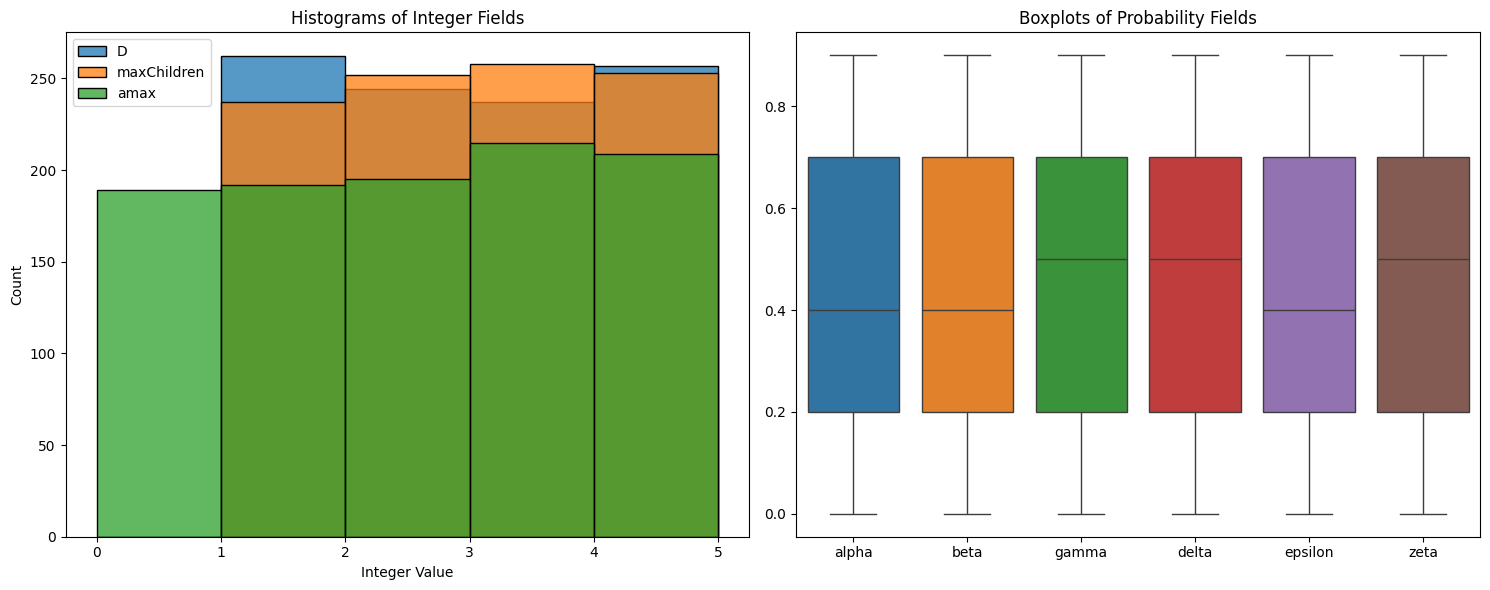

In [72]:
visualize_data(hyper_param_set)

#### TODO Rewrite this section
We start by creating a [ProbabilisticSearchFormGenerator](https://github.com/guyo13/Form-Lang/blob/react_compiler/src/generation/formGen.ts#L102) object which is implemented in JavaScript, using the default search hyper parameters and some hard-coded Component definitions.

Later on we will implement a random generator for the component definitions as well.

In [73]:
form_components = """
  component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}
  component Grid {}
  component Table {}
"""
field_components = """
  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }
  component mySelect {
    props {
      options
    }
  }
  component myRadio {
    props {
      options
    }
  }
  component myButton {
    props {
      text
    }
  }
  component myTextArea {
    props {
      rows
      cols
    }
  }
"""

### Create a data generation loop for the prompt data

#### Prompt-Data generation algorithm

Each training example consists of a randomly generated form, from-which we remove (or "mask") a random node, keep track of the removed node's parent and siblings.

The goal being to create a prompt that provides the masked form and describes in English the node that needs to be added along with its location in the form.

The algoithm is as follows:

* Generate a random Form - outputs $F$.
* Serialize the Form to FormLang code - outputs $s(F)$.
* Iterate Depth-First starting at the form's root.
  * For every node the probability of removing the node is $1 - \zeta^{depth(node)}, (0 < \zeta < 1)$ if no node was removed, else the probability is $ 0 $.
  * If a node is marked to be removed, recording its surrounding context and remove it from the tree. - $F \to (F', N, ctx(F, N))$.
* Serialize the modified Form to FormLang code - outputs $s(F')$.
* Generate Prompt instruction parts:
* Serialize the removed child node into plain English - outputs $eng(N)$.
* Serialize the Parent and Siblings nodes ids and node types (form/field) into plain English - outputs $eng(ctx(F, N))$.
* Output a dict consisting of $s(F), s(F'), eng(N), eng(ctx(F, N))$

The algorithm is implemented in TypeScript in the [generateRandomFormWithModification](https://github.com/guyo13/Form-Lang/blob/react_compiler/src/lib/generator.ts#L43) function.

We create a small dataset of 3000 random examples by using the JavaScript FormLang utilities library and the form generator object.

We copy from the form generator's output only the relevant fields which will make up the LLM prompt.

For each generated example we also compute the original form's AST and store it as part of the dataset.

In [74]:
import time
import pandas as pd
import concurrent.futures
import os
from tqdm import tqdm

def concat_components_code_with_form_code(form_code, form_components, field_components):
    """Concatenates the form code with the given components code that are referenced inside of it."""
    return f"{form_components}\n{field_components}\n{form_code}"

def create_prompt_data(generation_result, form_components, field_components):
    data = {
        "originalFormCode": concat_components_code_with_form_code(generation_result["serializedForm"], form_components, field_components),
        "modifiedFormCode": concat_components_code_with_form_code(generation_result["serializedModifiedForm"], form_components, field_components),
        "removedNodeEnglish": str(generation_result["removedNodeEnglish"]),
        "removedNodeContextEnglish": str(generation_result["removedNodeContextEnglish"]),
    }
    return data

def generate_and_process_hyperparams(hyperparams, examples_per_hyperparam, form_components, field_components):
    response = generate_random_forms(examples_per_hyperparam, form_components, field_components, hyperparams)
    if response is None:
        raise ValueError("Didnt generate any data")
    local_data = []
    for ex in response:
        prompt_data = create_prompt_data(ex, form_components, field_components)
        prompt_data = {**prompt_data, **hyperparams}
        local_data.append(prompt_data)
    return local_data

def process_example(example):
    resp = get_ast(example["originalFormCode"], True)
    errors = resp.get('errors', [])
    if len(errors) > 0:
        print(f"Error parsing generated code", errors)
        raise RuntimeError("Error parsing generated code")
    example["originalFormAst"] = resp["ast"]
    return example

def create_random_data(hyper_param_set, form_components, field_components, num_examples=100000):
    start_time = time.time()
    DATA = []
    n_hyperparams = len(hyper_param_set)
    examples_per_hyperparam = num_examples // n_hyperparams

    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = list(tqdm(
            executor.map(generate_and_process_hyperparams,
                         list(map(lambda x: x._asdict(), hyper_param_set.itertuples())),
                          [examples_per_hyperparam] * n_hyperparams, [form_components] * n_hyperparams, [field_components] * n_hyperparams),
            total=n_hyperparams, desc="Generating Forms using Hyperparams", unit="hyperparam set"
        ))

    for result in results:
        DATA.extend(result)

    ast_time = time.time()

    with concurrent.futures.ProcessPoolExecutor() as executor:
        DATA = list(tqdm(executor.map(process_example, DATA), total=len(DATA), desc="Generating ASTs"))

    end_time = time.time()

    # Create the DataFrame after all processing is done
    df = pd.DataFrame(DATA)
    print(f"Generation took {end_time - start_time} seconds. Total Ast generation time {end_time - ast_time} seconds")
    return df

In [82]:
%%time

examples = create_random_data(hyper_param_set, form_components, field_components, num_examples=100000)
examples.head()

Generating ASTs: 100%|██████████| 100000/100000 [04:14<00:00, 393.43it/s]


Generation took 272.2172021865845 seconds. Total Ast generation time 261.09270572662354 seconds
CPU times: user 40.5 s, sys: 11.1 s, total: 51.6 s
Wall time: 4min 33s


,originalFormCode,modifiedFormCode,removedNodeEnglish,removedNodeContextEnglish,Index,D,alpha,amax,beta,delta,epsilon,gamma,maxChildren,zeta,originalFormAst
0,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'gw' with state of type:...,* is a child of the form whose id is 'Jww'.,0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7,"{""$type"":""Form"",""name"":""Jww"",""component"":{""$ty..."
1,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\ta field whose id is 'Q' with state of type...,* is a child of the form whose id is 'hw'.,0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7,"{""$type"":""Form"",""name"":""v"",""component"":{""$type..."
2,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'Yw_w' with state of typ...,* is a child of the form whose id is 'q'.,0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7,"{""$type"":""Form"",""name"":""q"",""component"":{""$type..."
3,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'Sw_' with state of type...,* is a child of the form whose id is 'H_'.\n* ...,0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7,"{""$type"":""Form"",""name"":""H_"",""component"":{""$typ..."
4,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'c' with state of type: ...,* is a child of the form whose id is 'aw_w'.,0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7,"{""$type"":""Form"",""name"":""aw_w"",""component"":{""$t..."


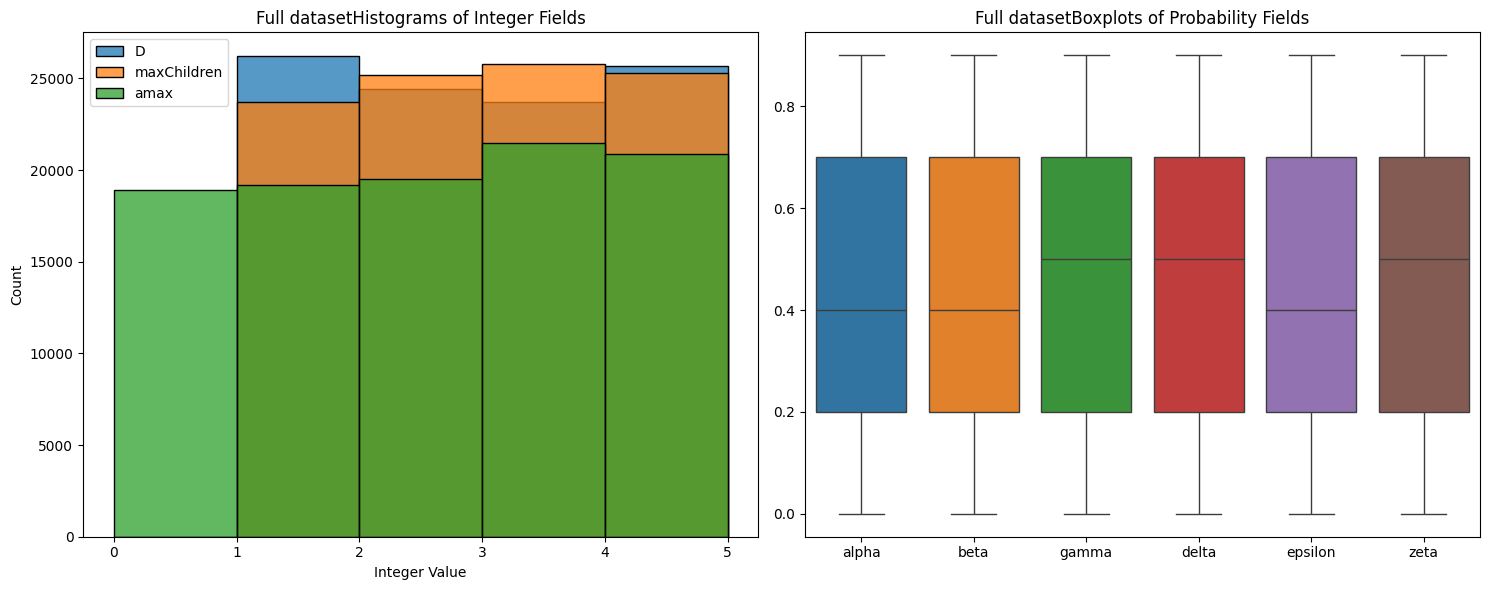

In [83]:
visualize_data(examples, title_prefix="Full dataset")

#### Example generated FormLang code and its AST

In [192]:
side_by_side_diff(examples["originalFormCode"][1132], examples['modifiedFormCode'][1132])

f,1,,f,1,
,2,component userDetailsContainer {},,2,component userDetailsContainer {}
,3,component formContainer {},,3,component formContainer {}
,4,component someOtherContainer {},,4,component someOtherContainer {}
,5,component OtherContainer2 {},,5,component OtherContainer2 {}
,6,component Grid {},,6,component Grid {}
,7,component Table {},,7,component Table {}
,8,,,8,
,9,,,9,
,10,component myTextBox {,,10,component myTextBox {
,11,props {,,11,props {


### Creating the user prompts

For each example in our synthetic dataset, we create the user prompt which will be used to train and test the LLM.

The user prompt consists of the modified FormLang code taken from each of our dataset examples along with the english description of the form element to add and its location (context) in the form.

In [193]:
def create_prompt(row):
    return (
            "```FormLang\n"
            f"{row['modifiedFormCode']}\n"
            "```\n"
            "The description of the form element you need to add:\n"
            f"{row['removedNodeEnglish']}\n"
            "The description of the context in the form where you should add the element:\n"
            f"The element to be added:\n{row['removedNodeContextEnglish']}\n"
           )

In [194]:
%%time

examples["userPrompt"] = examples.apply(create_prompt, axis=1)
examples.head()

CPU times: user 835 ms, sys: 7.14 ms, total: 842 ms
Wall time: 840 ms


,originalFormCode,modifiedFormCode,removedNodeEnglish,removedNodeContextEnglish,Index,D,alpha,amax,beta,delta,epsilon,gamma,maxChildren,zeta,originalFormAst,userPrompt
0,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\t\ta field whose id is 'Nw_w_ww' with state...,* is a child of the form whose id is 'aw'.\n* ...,0,3,0.9,4,0.2,0.3,0.0,0.3,3,0.9,"{""$type"":""Form"",""name"":""h"",""component"":{""$type...",```FormLang\n\n component userDetailsContaine...
1,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\ta form whose id is 'O' using the component...,* is a child of the form whose id is 'Kw'.,0,3,0.9,4,0.2,0.3,0.0,0.3,3,0.9,"{""$type"":""Form"",""name"":""Fw"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...
2,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\t\ta field whose id is 'Y_www__ww__www_ww_w...,* is a child of the form whose id is 'ow'.\n* ...,0,3,0.9,4,0.2,0.3,0.0,0.3,3,0.9,"{""$type"":""Form"",""name"":""M"",""component"":{""$type...",```FormLang\n\n component userDetailsContaine...
3,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\t\ta field whose id is 'K_' using the compo...,* is a child of the form whose id is 'Jw'.\n* ...,0,3,0.9,4,0.2,0.3,0.0,0.3,3,0.9,"{""$type"":""Form"",""name"":""T"",""component"":{""$type...",```FormLang\n\n component userDetailsContaine...
4,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\t\ta field whose id is 'Lw' with state of t...,* is a child of the form whose id is 'v'.\n* i...,0,3,0.9,4,0.2,0.3,0.0,0.3,3,0.9,"{""$type"":""Form"",""name"":""S_ww___w_w___ww_"",""com...",```FormLang\n\n component userDetailsContaine...


##### Example User Prompt vs. Modified Code

In [195]:
side_by_side_diff(examples["modifiedFormCode"][1132], examples['userPrompt'][1132])

n,,,n,1,```FormLang
,1,,,2,
,2,component userDetailsContainer {},,3,component userDetailsContainer {}
,3,component formContainer {},,4,component formContainer {}
,4,component someOtherContainer {},,5,component someOtherContainer {}
,5,component OtherContainer2 {},,6,component OtherContainer2 {}
,6,component Grid {},,7,component Grid {}
,7,component Table {},,8,component Table {}
,8,,,9,
,9,,,10,
,10,component myTextBox {,,11,component myTextBox {


### Creating a Dataset on HuggingFace using `Datasets`

First we've manually created a Dataset repository on the hugging-face hub for our [form-lang-examples](https://huggingface.co/datasets/guy-or/form-lang-examples) .

We then convert our `examples` DataFrame into a Dataset object and upload it to the Hub.


In [196]:
ds = Dataset.from_pandas(examples)
ds.push_to_hub("guy-or/form-lang-examples", "100k_single_omission")
ds

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Dataset({
    features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'Index', 'D', 'alpha', 'amax', 'beta', 'delta', 'epsilon', 'gamma', 'maxChildren', 'zeta', 'originalFormAst', 'userPrompt'],
    num_rows: 100000
})

# Zero-shot evaluation and Training using Llama 3.2-1B as a foundation model

We've selected Llama 3.2 1B Instruct as a foundantion model of our experimentation.

This is choice is driven by the popularity of the model and the abundace of resources and examples available online. Specifically the 1B version was chosen because it can run on consumer hardware and can be trained on free cloud resources.

Another important factor in this choice is Llama's large context size of 128K tokens, this allows us to experiment with large prompts and opens the door for building complex AI agents that can be fed with `FormLang`'s compiler messages and user feedback and adjust their responses.

Successfully demonstrating performance improvement after training the 1B version will justify further time and cost investment required for training larger models.

## Dataset Loading and Pre-processing

### Loading the Dataset from HuggingFace using `Datasets`

We load the Dataset from the Hub using `load_dataset` function. The dataset contains the raw user prompt and expected outputs.

In the next steps we will use these fields to create a full prompt which includes our system prompt and finally tokenize the prompt in preparation for running the model.

In [6]:
from datasets import load_dataset

ds_100k_single_omission = load_dataset("guy-or/form-lang-examples", "100k_single_omission")
ds_100k_single_omission_all = ds_100k_single_omission['train']
ds_100k_single_omission_all

Dataset({
    features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'Index', 'D', 'alpha', 'amax', 'beta', 'delta', 'epsilon', 'gamma', 'maxChildren', 'zeta', 'originalFormAst', 'userPrompt'],
    num_rows: 100000
})

### Pre-processing using the Chat Template

In order to create prompts that effectively describe the task to our Llama 3.2 model, we need to format our prompt in a way that the model was trained to respond to.

This is called a [Prompt Template](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1/#prompt-template), which consists of a **System prompt** which provides the initial context and guidelines for the model, followed by a **User prompt** containing the request and relevant data.

#### Loading the Llama Tokenizer

We load Llama's tokenizer using Huggingface `AutoTokenizer` class and leverage its [Chat templates](https://huggingface.co/docs/transformers/v4.48.2/en/chat_templating#introduction) capabilities which exposes a simple API for formatting our prompts into Llama's required Prompt Template.

In [7]:
from transformers import AutoTokenizer

llama3_tok_for_inference = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct", padding_side="left")
llama3_tok_for_inference.pad_token = "<|finetune_right_pad_id|>"

#### System prompt

Our System prompt instructs the LLM to generate the original form (the `originalFormCode` column) given the data present in the user prompt which we already created in the Dataset generation part.

In [8]:
def get_system_prompt():
    return (
        "You are a code generation AI assistant.\n"
        "Your job is to generate valid FormLang code according to the instructions given below:\n"
        "Inspect the following FormLang Form definition, the start of the code will be denoted with ```FormLang and its end with ``` .\n"
        "After inspection, complete the Form's code according to the given a description of a new form element and a description of its location in the form.\n"
        "You may assume that the new form element to be added is always either a 'form' or a 'field'.\n"
        "Your output must be valid and compiler-friendly FormLang code only.\n"
        "If you are unsure of the FormLang syntax, try to infer it from the form code which is given below as an input."
        "Your answer will be evaluated using an AST comparison of your code to the expected code.\n"
        "Assume that the input code is valid and requires no modification other than the NEW code you must generate.\n"
        "You must output plain FormLang code without any additional text or delimiters.\n"
        "You must not change any part of the original input code other than adding the required element.\n"
    )



#### Creating the full chat prompts

We create an `inferencePrompt` column to store the input prompt which contains the templated system and user prompts. **This column is used for inference only.**

Since our model's generated text gets appended (according to the prompt template format) to the input prompt, we also create a `chat` column containing the final expected model output. **This column will be used for training the model on a Causal Language Modelling task**. This task uses the model inputs (the `chat` column) shifted by one position to the right as labels.

In [9]:
def get_system_and_user_messages(userPrompt):
    return [
        {"role": "system", "content": get_system_prompt()},
        {"role": "user", "content": userPrompt}]

def get_full_conversation_messages(userPrompt, expectedOutput):
    messages = get_system_and_user_messages(userPrompt)
    messages.append({"role": "assistant", "content": expectedOutput})
    return messages

def preprocess_func(example, tokenizer):
    inference_prompt = tokenizer.apply_chat_template(get_system_and_user_messages(example["userPrompt"]), tokenize=False, add_generation_prompt=True)
    chat = tokenizer.apply_chat_template(get_full_conversation_messages(example["userPrompt"], example['originalFormCode']), tokenize=False, add_generation_prompt=False)
    return {"inferencePrompt": inference_prompt, "chat": chat}

In [10]:
ds_100k_with_prompts = ds_100k_single_omission_all.map(preprocess_func, batched=False, fn_kwargs={"tokenizer": llama3_tok_for_inference})
ds_100k_with_prompts

Dataset({
    features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'Index', 'D', 'alpha', 'amax', 'beta', 'delta', 'epsilon', 'gamma', 'maxChildren', 'zeta', 'originalFormAst', 'userPrompt', 'inferencePrompt', 'chat'],
    num_rows: 100000
})

In [11]:
side_by_side_diff(ds_100k_with_prompts[0]['inferencePrompt'], ds_100k_with_prompts[0]['chat'])

f,1,<|begin_of_text|><|start_header_id|>system<|end_header_id|>,f,1,<|begin_of_text|><|start_header_id|>system<|end_header_id|>
,2,,,2,
,3,Cutting Knowledge Date: December 2023,,3,Cutting Knowledge Date: December 2023
,4,Today Date: 24 Mar 2025,,4,Today Date: 24 Mar 2025
,5,,,5,
,6,You are a code generation AI assistant.,,6,You are a code generation AI assistant.
,7,Your job is to generate valid FormLang code according to the instructions given below:,,7,Your job is to generate valid FormLang code according to the instructions given below:
,8,"Inspect the following FormLang Form definition, the start of the code will be denoted with ```FormLang and its end with ``` .",,8,"Inspect the following FormLang Form definition, the start of the code will be denoted with ```FormLang and its end with ``` ."
,9,"After inspection, complete the Form's code according to the given a description of a new form element and a description of its location in the form.",,9,"After inspection, complete the Form's code according to the given a description of a new form element and a description of its location in the form."
,10,You may assume that the new form element to be added is always either a 'form' or a 'field'.,,10,You may assume that the new form element to be added is always either a 'form' or a 'field'.
,11,Your output must be valid and compiler-friendly FormLang code only.,,11,Your output must be valid and compiler-friendly FormLang code only.


#### Creating the Train-Test split

First I remove any duplicate rows (considering the `chat` column for uniqueness) that may have been generated. With the seed I used to generate the dataset there are

I allocate 1000 (~1%) for the test split and the rest  will be used for training.

Since we are able to generate arbitrarily large amounts of data with different distributions, these percentages does not matter too much. I chose to keep the test size small because inference is compute-intensive and can easily double the training time if the test dataset is too large.

I plot the hyperparamters statistics of the Train and Test split to make sure our sampling is not too biased and indeed the plots show similar statistics.

In [12]:
from datasets import Dataset

ds_100k_with_prompts = Dataset.from_polars(ds_100k_with_prompts.to_polars().unique(subset="chat"))
perc_1k = 1000 / len(ds_100k_with_prompts)
ds_100k_splits = ds_100k_with_prompts.train_test_split(test_size=perc_1k, shuffle=True, seed=42)
ds_100k_train, ds_100k_test = ds_100k_splits["train"], ds_100k_splits["test"]
ds_100k_train, ds_100k_test

(Dataset({
     features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'Index', 'D', 'alpha', 'amax', 'beta', 'delta', 'epsilon', 'gamma', 'maxChildren', 'zeta', 'originalFormAst', 'userPrompt', 'inferencePrompt', 'chat'],
     num_rows: 98974
 }),
 Dataset({
     features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'Index', 'D', 'alpha', 'amax', 'beta', 'delta', 'epsilon', 'gamma', 'maxChildren', 'zeta', 'originalFormAst', 'userPrompt', 'inferencePrompt', 'chat'],
     num_rows: 1000
 }))

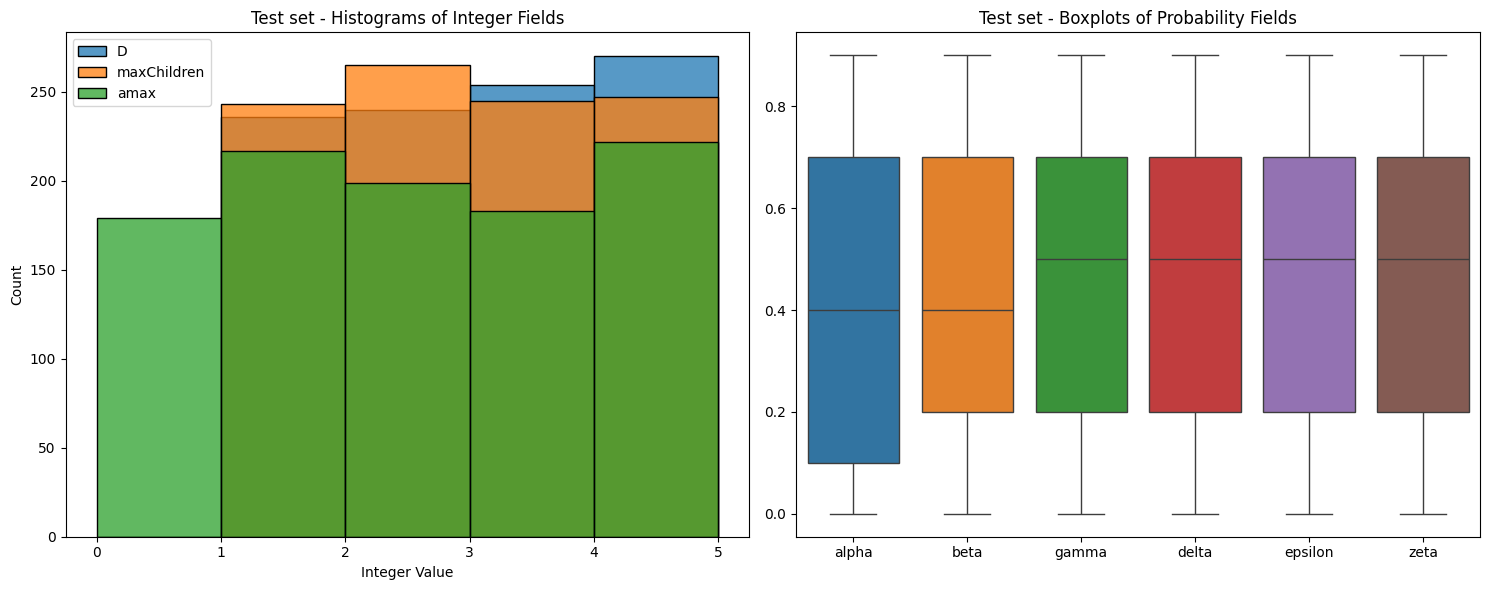

In [13]:
visualize_data(ds_100k_test.to_pandas(), title_prefix="Test set - ")

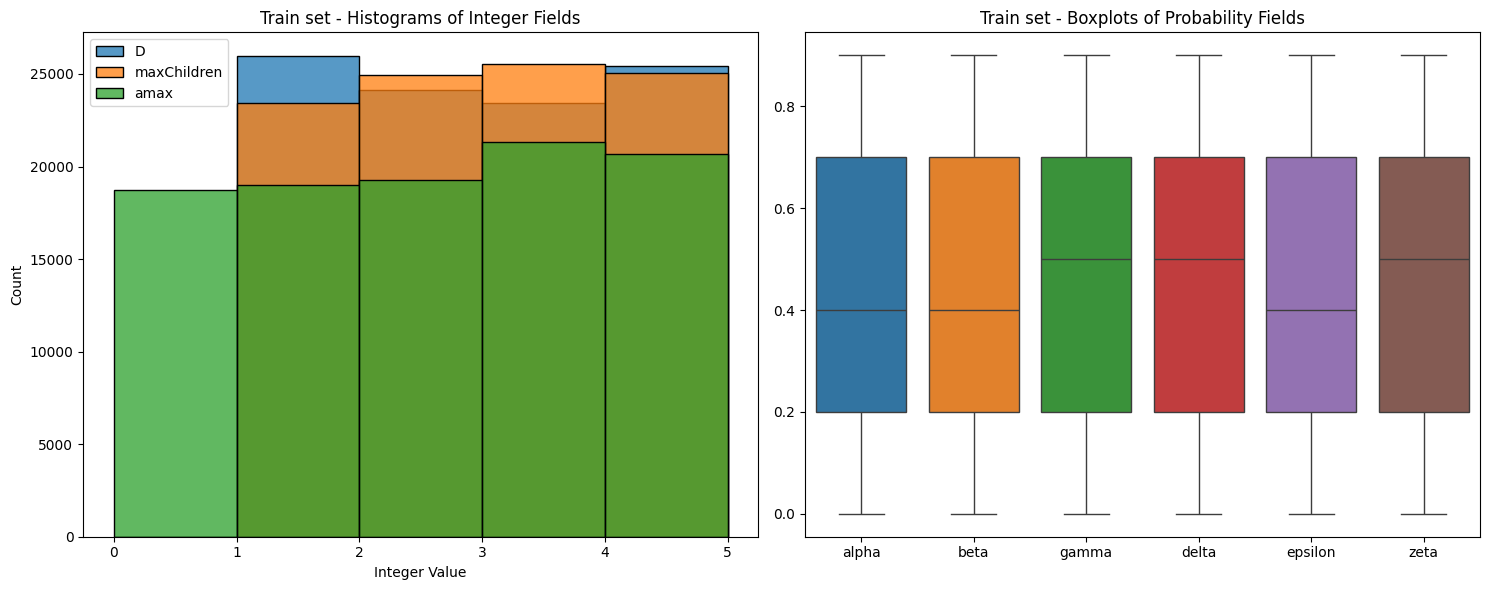

In [14]:
visualize_data(ds_100k_train.to_pandas(), title_prefix="Train set - ")

## Post-Processing Utils

We create several utility functions for post processing the prompt data

### Extracting the model's response from the output text

Our model's raw output is a concatenation of the input and the generated text following Llama's Prompt Template semantics.

In order to extract the generated code we first need to identify the model's latest response by extracting all the text between the special `<|start_header_id|>assistant<|end_header_id|>` and `<|eot_id|>` tokens.

In [15]:
import re

def extract_latest_assistant_response(text):
    """
    Extracts the model's response from the output text.

    Args:
        text: The output text from the model.

    Returns:
        The extracted model response, or None if no response is found.
    """
    match = re.findall(r"<\|start_header_id\|>assistant<\|end_header_id\|>(.*?)<\|eot_id\|>", text, re.DOTALL)
    if match:
        return match[-1].strip()  # Return the latest occurrence
    else:
        return ""


### Extracting FormLang code from LLM output

The LLM might ignore the instruction to output plain code without the "```FormLang" delimiter, in that case we should try to extract the contents.

In [16]:
import re

def extract_code_block(text, lang):
  """
  Extracts a code block from a string.

  Args:
    text: The string containing the code block.
    lang: The name of the language the code block is written in.

  Returns:
    The code block, or None if no code block is found.
  """
  if text is None:
    return ""
  pattern = f"```{lang}\n(.*?)```"
  match = re.search(pattern, text, re.DOTALL)
  if match:
    return match.group(1).strip()
  return ""

def extract_llm_formlang_output(text, is_completion_only=False):
    # Strip leading and trailing whitespace and check for delimiters
    text = text.strip()
    assistant_response = text if is_completion_only else extract_latest_assistant_response(text)
    return extract_code_block(assistant_response, "FormLang") or assistant_response

### Running inference on a single example

In [17]:
import torch
def clear_mem():
    """Clear unused GPU memory used by the python process"""
    import gc
    gc.collect()
    torch.cuda.empty_cache()

In [18]:
def run_inference(model, tok, example, cuda=True):
    """Runs pre-processing, inference and post-processing on a single example."""
    example_inputs = tok(example, return_tensors="pt")
    if cuda:
        example_inputs = example_inputs.to("cuda")
    with torch.no_grad():
      example_outputs = model.generate(**example_inputs, max_new_tokens=10000)
    generated_text = tok.decode(example_outputs[0], skip_special_tokens=False)
    del example_inputs
    del example_outputs
    generated_code = extract_llm_formlang_output(generated_text)
    ast = get_ast(generated_code)
    return {"generated_code": generated_code, "generated_text": generated_text, "ast": ast}

### Defining the Performance metrics TODO REWRITE

Before attempting to train the model, we want to define perfomance metrics for the code generation task and evaluate the base model performance on some of our data in order to establish a baseline for performance.

We tried several metrics:

* Exact Match
* BLEU (Geometric mean over n-gram BLEU with $n \in \{1,2,3,4\}$ and Berevity Penalty applied to the mean).
* ROUGE
* METEOR
* ChrF (Suggested as the best metric according to Mikhail Evtikhiev, Egor Bogomolov, Yaroslav Sokolov, Timofey Bryksin,
[Out of the BLEU paper](https://www.sciencedirect.com/science/article/abs/pii/S016412122300136X))

##### TODO Rewrite this section

BLUE and ROUGE are standard metrics for measuring text generation performance when we want to compare the model's output to a desired output.

In the case of code generation, these metrics may not accurately reflect the quality of the model's output when applied to the source code and therefore we will try to apply them both on the serialized AST (in JSON format) of the generated code as well as the code itself and the raw output of the model vs the expected one.

**(TBD)** Try CodeBLEU and `apted` for tree edit distance algorithms that might better reflect the model's performance.

### Loading the metrics and creating evaluators

#### Computing the metrics over our dataset columns
 #### TODO REWRITE
As an example to test the reliability of our metrics (specifically the BLEU and ROUGE scores), we check their average values on the examples from our train dataset.

We compare the similarity of the following pairs of data:

1) The expected raw output of the model (`chat`) compared to our `inferencePrompt`.

2) The original form source code (`originalFormCode`) and the modified form code (`modifiedFormCode`).

3) The AST of the original form source code and the AST of the modified form code.

In [19]:
import multiprocessing

def extract_metric_relevant_columns(metrics_output):
  # {'bleu': 0.8429359658014339,
  # 'precisions': [0.9991243684963839,
  # 0.9964290396238203,
  # 0.9945622915127816,
  # 0.9943585183190857],
  # 'brevity_penalty': 0.8462220852319774,
  # 'length_ratio': 0.8569175306304484,
  # 'translation_length': 2740879,
  # 'reference_length': 3198533,
  # 'rouge1': 0.8370146985702014,
  # 'rouge2': 0.8334233528574165,
  # 'rougeL': 0.8369070588232945,
  # 'rougeLsum': 0.8370885974782589,
  # 'exact_match': 0.0,
  # 'meteor': 0.6904226543462031,
  # 'score': 87.7747112051328,
  # 'char_order': 6,
  # 'word_order': 0,
  # 'beta': 2}
  metrics = {}
  if 'bleu' in metrics_output:
    metrics['bleu'] = metrics_output['bleu']
    for i in range(len(metrics_output['precisions'])):
      metrics[f'bleu_{i+1}_gram'] = metrics_output['precisions'][i]
    metrics['bleu_brevity_penalty'] = metrics_output['brevity_penalty']
    metrics['bleu_length_ratio'] = metrics_output['length_ratio']
  if 'rouge1' in metrics_output:
    metrics['rouge1'] = metrics_output['rouge1']
  if 'rouge2' in metrics_output:
    metrics['rouge2'] = metrics_output['rouge2']
  if 'rougeL' in metrics_output:
    metrics['rougeL'] = metrics_output['rougeL']
  if 'rougeLsum' in metrics_output:
    metrics['rougeLsum'] = metrics_output['rougeLsum']
  if 'exact_match' in metrics_output:
    metrics['exact_match'] = metrics_output['exact_match']
  if 'meteor' in metrics_output:
    metrics['meteor'] = metrics_output['meteor']
  if 'score' in metrics_output:
    metrics['chrf'] = metrics_output['score']
  return metrics

def compute_metric_and_return_dataframe(dataset, metric_fn, get_predictions, get_references):
  column_names = list(dataset.features)
  results = dataset.map(
      lambda example: extract_metric_relevant_columns(
          metric_fn.compute(predictions=get_predictions(example),
                            references=get_references(example))
          ),
      batched=False,
      num_proc=multiprocessing.cpu_count(),
      remove_columns=column_names
      )
  return results.to_pandas()

In [20]:
import evaluate
import numpy as np
from datasets import Dataset
from tqdm import tqdm

training_metrics = evaluate.load("exact_match", module_type="metric", keep_in_memory=True)

def prefix_dict_keys(d, prefix):
  return {f"{prefix}_{k}": v for k, v in d.items()}

def iter_ast(source_codes, desc=""):
  asts = []
  for i in tqdm(range(len(source_codes)), desc=desc):
    code = source_codes[i]
    asts.append(get_ast(code)['ast'])
  return asts

def get_labels_predictions_for_completion_only(tokenizer, labels, predictions):
  batch_size, seq_len = labels.shape
  # Vectorized way of finding the start of the completion
  completion_start_indices = np.argmax(labels != -100, axis=1)
  aligned_predictions = []
  aligned_labels = []
  # Trim sequence from the left so that the first element is the start token of the completion
  for i in range(batch_size):
      aligned_predictions.append(predictions[i, completion_start_indices[i]:])
      aligned_labels.append(labels[i, completion_start_indices[i]:])
  # Pad to the maximum length in the batch
  padded_predictions = []
  padded_labels = []
  for pred, lab in zip(aligned_predictions, aligned_labels):
      padded_predictions.append(np.pad(pred, (0, seq_len - len(pred)), 'constant', constant_values=tokenizer.pad_token_id))
      padded_labels.append(np.pad(lab, (0, seq_len - len(lab)), 'constant', constant_values=tokenizer.pad_token_id))

  # Convert lists with completions to numpy matrices
  aligned_predictions = np.array(padded_predictions)
  aligned_labels = np.array(padded_labels)

  # Replace any -100 values to make sure we are tokenizer-safe (could be due to right-padding for example)
  aligned_predictions = np.where(aligned_predictions == -100 , tokenizer.pad_token_id, aligned_predictions)
  aligned_labels = np.where(aligned_labels == -100, tokenizer.pad_token_id, aligned_labels)
  # We skip special tokens because we know where the completion starts and we assume it ends at the end of the sequence.
  raw_text_predictions = tokenizer.batch_decode(aligned_predictions, skip_special_tokens=True)
  raw_text_labels = tokenizer.batch_decode(aligned_labels, skip_special_tokens=True)

  return raw_text_labels, raw_text_predictions

def get_labels_predictions(tokenizer, labels, predictions):
  # Replace any -100 values to make sure we are tokenizer-safe (due to padding)
  predictions = np.where(predictions == -100 , tokenizer.pad_token_id, predictions)
  labels = np.where(labels == -100, tokenizer.pad_token_id, labels)
  raw_text_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=False)
  raw_text_labels = tokenizer.batch_decode(labels, skip_special_tokens=False)
  return raw_text_labels, raw_text_predictions

def compute_exact_match_metrics(eval_pred, packed=False, tokenizer=None, is_completion_only=False):
    logits, labels = eval_pred
    if len(logits) == 3:
      # If the trainer does not pre-process the output logits we have to do it here
      print("Taking argmax over logits")
      # The predicted token ID is the one with the maximum logit
      predictions = np.argmax(logits, axis=-1)
    else:
      # If the trainer does the argmax for us then the logits are already the predictions
      predictions = logits

    print("Logits shape:", logits.shape)
    print("Labels shape:", labels.shape)
    print("Predictions shape:", predictions.shape)

    if is_completion_only:
      raw_text_labels, raw_text_predictions = get_labels_predictions_for_completion_only(tokenizer, labels, predictions)
    else:
      raw_text_labels, raw_text_predictions = get_labels_predictions(tokenizer, labels, predictions)

    source_code_predictions = [extract_llm_formlang_output(output, is_completion_only=is_completion_only) for output in raw_text_predictions]
    source_code_references = []
    for label in raw_text_labels:
      ref = extract_llm_formlang_output(label, is_completion_only=is_completion_only)
      if ref == "" or ref is None:
        raise ValueError(f"ERROR, reference source code is empty! '{ref}'\nlabel:\n{label}")
      source_code_references.append(ref)
    source_code_eval = Dataset.from_dict({"source_code_predictions": source_code_predictions, "source_code_references": source_code_references})
    source_code_avg_metrics = compute_metric_and_return_dataframe(source_code_eval, training_metrics, lambda example: [example["source_code_predictions"]], lambda example: [example["source_code_references"]]).mean().to_dict()

    # Evaluate the AST output
    ast_predictions = iter_ast(source_code_predictions, desc="Computing AST - Predictions")
    ast_references = iter_ast(source_code_references, desc="Computing AST - References")
    ast_eval = Dataset.from_dict({"ast_predictions": ast_predictions, "ast_references": ast_references})
    ast_avg_metrics = compute_metric_and_return_dataframe(source_code_eval, training_metrics, lambda example: [example["source_code_predictions"]], lambda example: [example["source_code_references"]]).mean().to_dict()

    all_metrics = {}
    all_metrics.update(prefix_dict_keys(source_code_avg_metrics, "source_code"))
    all_metrics.update(prefix_dict_keys(ast_avg_metrics, "ast"))

    return all_metrics


In [21]:

def validate_train_settings(tokenizer, eval_dataset, train_dataset, dataset_text_field, max_seq_length):
  # Check that the max_seq_length is not shorter than our longest prompt
  eval_prompts_tokenized = tokenizer(eval_dataset[dataset_text_field])["input_ids"]
  train_prompts_tokenized = tokenizer(train_dataset[dataset_text_field])["input_ids"]
  eval_longest_prompt_index = np.argmax(np.array(list(map(lambda x:len(x), eval_prompts_tokenized))))
  train_longest_prompt_index = np.argmax(np.array(list(map(lambda x:len(x), train_prompts_tokenized))))
  eval_longest_prompt = eval_prompts_tokenized[eval_longest_prompt_index]
  train_longest_prompt = train_prompts_tokenized[train_longest_prompt_index]
  longest_prompt_length = max(len(eval_longest_prompt), len(train_longest_prompt))
  if longest_prompt_length > max_seq_length:
    raise ValueError(f"max_seq_length of {max_seq_length} is shorter than the longest prompt of length {longest_prompt_length}")


In [22]:
def train_with_lora(trainer, resume_from_checkpoint=False):
  train_result = trainer.train(resume_from_checkpoint=resume_from_checkpoint)
  clear_mem()
  return train_result

def log_trainer_metrics(trainer, train_result, train_dataset):
  metrics = train_result.metrics
  metrics["train_samples"] = len(train_dataset)
  trainer.log_metrics("train", metrics)
  trainer.save_metrics("train", metrics)
  trainer.save_state()

## Fine-Tuning LoRA adapter for LLama 3.2 1B using Unsloth.ai

In [24]:
import unsloth
from unsloth import FastLanguageModel, is_bfloat16_supported
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from transformers import DataCollatorForSeq2Seq
import numpy as np
from unsloth.chat_templates import train_on_responses_only

def get_model_and_tokenizer(model_id: str, max_seq_length: int, dtype: str=None, load_in_4bit:bool=False):
  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name = model_id,
      max_seq_length = max_seq_length,
      dtype = dtype,
      load_in_4bit = load_in_4bit,
  )
  return model, tokenizer

def get_unsloth_peft_model(model, lora_config:LoraConfig, random_state:int=None):
  return FastLanguageModel.get_peft_model(
    model,
    use_gradient_checkpointing = "unsloth",
    r = lora_config.r,
    target_modules = lora_config.target_modules,
    lora_alpha = lora_config.lora_alpha,
    lora_dropout = lora_config.lora_dropout,
    bias = lora_config.bias,
    random_state = random_state,
)

def get_unsloth_trainer(model_id, lora_config: LoraConfig, output_dir, train_dataset,
                        eval_dataset, dataset_text_field, compute_metrics, max_seq_length,
                        packing=False, push_to_hub=False, num_train_epochs=1, seed: int=None, batch_size: int = 2,
                        is_completion_only:bool = False, should_validate_train_settings=True, eval_steps=0.05):

  model, tokenizer = get_model_and_tokenizer(model_id, max_seq_length)
  model = get_unsloth_peft_model(model, lora_config, random_state=seed)

  if should_validate_train_settings:
    validate_train_settings(tokenizer, eval_dataset, train_dataset, dataset_text_field, max_seq_length)

  training_args = SFTConfig(
      max_seq_length = max_seq_length, # Or tokenizer.model_max_length,
      num_train_epochs=num_train_epochs,
      max_steps=-1,
      fp16 = not is_bfloat16_supported(),
      bf16 = is_bfloat16_supported(),
      do_eval = True,
      eval_strategy = "steps",
      eval_steps = eval_steps,
      # Insanely important otherwise all the evaluations are going to OOM the GPU!!!
      eval_accumulation_steps = 10,
      per_device_eval_batch_size=batch_size,
      save_strategy = "steps",
      save_steps = 0.05,
      logging_strategy = "steps",
      logging_steps = 0.05,
      log_level = "info",
      report_to = "tensorboard",
      optim = "adamw_8bit",
      learning_rate = 2e-4,
      lr_scheduler_type = "linear",
      warmup_steps = 5,
      weight_decay = 0.01,
      gradient_accumulation_steps = 20,
      per_device_train_batch_size = batch_size,
      output_dir = output_dir,
      overwrite_output_dir = True,
      push_to_hub = push_to_hub,
      hub_strategy = "all_checkpoints",
      save_total_limit = None,
      seed = seed,
      dataset_text_field = dataset_text_field,
      packing = packing,
  )

  from functools import partial
  compute_metrics = partial(compute_metrics, packed=packing, tokenizer=tokenizer, is_completion_only=is_completion_only)

  trainer = SFTTrainer(
          model=model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          tokenizer=tokenizer,
          data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
          compute_metrics=compute_metrics,
          # This allows us to reduce the size of the logits stored on the GPU and use a larger eval_accumulation_steps value
          preprocess_logits_for_metrics=lambda logits, labels: torch.argmax(logits, dim=-1),
      )
  if is_completion_only:
    # We don't want to train the model on predicting the instruction but only the response.
    # Unsloth has a handy util to do this,
    # we could have also used DataCollatorForCompletionOnlyLM from the huggingface TRL library to do this
    trainer = train_on_responses_only(
      trainer,
      instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
      response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
    )

  return trainer, training_args, model, tokenizer

In [25]:
output_dir = "./formlang-lora-unsloth-2-Llama-3.2-1B-Instruct"

peft_config = LoraConfig(
          r=64,
          lora_alpha=16,
          lora_dropout=0,
          bias="none",
          task_type="CAUSAL_LM",
          target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
)
trainer, training_args, model, tokenizer = get_unsloth_trainer(
    "unsloth/Llama-3.2-1B-Instruct",
    peft_config,
    output_dir,
    ds_100k_train,
    ds_100k_test,
    "chat",
    compute_exact_match_metrics,
    4096,
    push_to_hub=False,
    num_train_epochs=2,
    seed=42,
    batch_size=4,
    should_validate_train_settings=False,
    eval_steps=20
)

==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.3.18 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["chat"] (num_proc=12):   0%|          | 0/98974 [00:00<?, ? examples/s]

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["chat"] (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Using auto half precision backend


In [26]:
from unsloth import unsloth_train
trainer_stats = unsloth_train(trainer)

The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat. If removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 98,974 | Num Epochs = 2 | Total steps = 2,474
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 20
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 20 x 1) = 80
 "-____-"     Trainable parameters = 45,088,768/1,280,903,168 (3.52%

Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss,Source Code Exact Match,Ast Exact Match
20,No log,0.357646,0.162000,0.162000
40,No log,0.163841,0.512000,0.512000
60,No log,0.138484,0.722000,0.722000
80,No log,0.128769,0.832000,0.832000
100,No log,0.117119,0.910000,0.910000
120,No log,0.107709,0.932000,0.932000
140,0.349400,0.106641,0.956000,0.956000


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat. If removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Logits shape: (1000, 3011)
Labels shape: (1000, 3011)
Predictions shape: (1000, 3011)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Computing AST - Predictions:   2%|▏         | 16/1000 [00:00<00:41, 23.99it/s]2025-03-24 13:59:25,106 - ERROR - api_client - <ipython-input-3-b5803226226c> - get_ast - 17 - get_ast Failed error response.
ERROR:api_client:get_ast Failed error response.
Computing AST - Predictions:   2%|▏         | 24/1000 [00:01<00:34, 28.02it/s]2025-03-24 13:59:25,389 - ERROR - api_client - <ipython-input-3-b5803226226c> - get_ast - 17 - get_ast Failed error response.
ERROR:api_client:get_ast Failed error response.
Computing AST - Predictions:   4%|▍         | 41/1000 [00:01<00:23, 41.40it/s]2025-03-24 13:59:25,804 - ERROR - api_client - <ipython-input-3-b5803226226c> - get_ast - 17 - get_ast Failed error response.
ERROR:api_client:get_ast Failed error response.
Computing AST - Predictions:   5%|▌         | 53/1000 [00:01<00:19, 48.38it/s]2025-03-24 13:59:25,976 - ERROR - api_client - <ipython-input-3-b5803226226c> - get_ast - 17 - get_ast Failed error response.
ERROR:api_client:get_ast Failed error re

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat. If removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4


Logits shape: (1000, 3011)
Labels shape: (1000, 3011)
Predictions shape: (1000, 3011)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 1000/1000 [00:09<00:00, 106.99it/s]


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat. If removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4


Logits shape: (1000, 3011)
Labels shape: (1000, 3011)
Predictions shape: (1000, 3011)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 1000/1000 [00:08<00:00, 112.66it/s]


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat. If removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4


Logits shape: (1000, 3011)
Labels shape: (1000, 3011)
Predictions shape: (1000, 3011)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 1000/1000 [00:08<00:00, 113.67it/s]


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat. If removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4


Logits shape: (1000, 3011)
Labels shape: (1000, 3011)
Predictions shape: (1000, 3011)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 1000/1000 [00:08<00:00, 118.46it/s]


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat. If removedNodeContextEnglish, removedNodeEnglish, modifiedFormCode, originalFormAst, beta, zeta, userPrompt, maxChildren, amax, delta, originalFormCode, Index, alpha, D, epsilon, inferencePrompt, gamma, chat are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4


Logits shape: (1000, 3011)
Labels shape: (1000, 3011)
Predictions shape: (1000, 3011)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 1000/1000 [00:08<00:00, 114.81it/s]


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-2-Llama-3.2-1B-Instruct/checkpoint-124
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_

Logits shape: (1000, 3011)
Labels shape: (1000, 3011)
Predictions shape: (1000, 3011)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 1000/1000 [00:08<00:00, 114.80it/s]


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [55]:
# from functools import partial

# trainer.compute_metrics = partial(compute_exact_match_metrics, packed=False, tokenizer=tokenizer, is_completion_only=True)
# trainer.args.eval_steps = 25

In [51]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: originalFormCode, originalFormAst, delta, zeta, amax, modifiedFormCode, userPrompt, inferencePrompt, removedNodeContextEnglish, removedNodeEnglish, gamma, maxChildren, epsilon, Index, beta, D, chat, alpha. If originalFormCode, originalFormAst, delta, zeta, amax, modifiedFormCode, userPrompt, inferencePrompt, removedNodeContextEnglish, removedNodeEnglish, gamma, maxChildren, epsilon, Index, beta, D, chat, alpha are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4


Step,Training Loss,Validation Loss,Source Code Exact Match,Ast Exact Match
7,No log,0.083510,0.000000,0.000000
14,No log,0.030821,0.000000,0.000000
21,No log,0.015768,0.000000,0.000000
28,No log,0.008517,0.000000,0.000000


Logits shape: (1000, 2555)
Labels shape: (1000, 2555)
Predictions shape: (1000, 2555)
!!@#!@#!@# CALLING ### get_labels_predictions_for_completion_only
First Label Source Code:
component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}
  component Grid {}
  component Table {}


  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }
  component mySelect {
    props {
      options
    }
  }
  component myRadio {
    props {
      options
    }
  }
  component myButton {
    props {
      text
    }
  }
  component myTextArea {
    props {
      rows
      cols
    }
  }

form qwwww_w {
	comp mySelect 
	
	form s_ {
		comp myRadio 
		

	}

	field o {
		comp formContainer 
		
	}
	field kw {
		comp formContainer 
		
	}
}
###
Fi

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 1000/1000 [00:08<00:00, 113.75it/s]


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

{'eval_loss': 0.008517309091985226,
 'eval_source_code_exact_match': 0.0,
 'eval_ast_exact_match': 0.0}

In [56]:
from unsloth import unsloth_train
trainer_stats = unsloth_train(trainer)

The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: originalFormCode, originalFormAst, delta, zeta, amax, modifiedFormCode, userPrompt, inferencePrompt, removedNodeContextEnglish, removedNodeEnglish, gamma, maxChildren, epsilon, Index, beta, D, chat, alpha. If originalFormCode, originalFormAst, delta, zeta, amax, modifiedFormCode, userPrompt, inferencePrompt, removedNodeContextEnglish, removedNodeEnglish, gamma, maxChildren, epsilon, Index, beta, D, chat, alpha are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 98,974 | Num Epochs = 2 | Total steps = 2,474
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 20
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 20 x 1) = 80
 "-____-"     Trainable parameters = 45,088,768/1,280,903,168 (3.52%

Step,Training Loss,Validation Loss,Source Code Exact Match,Ast Exact Match
25,No log,0.001826,0.000000,0.000000
50,No log,0.000707,0.000000,0.000000
75,No log,0.000415,0.000000,0.000000


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: originalFormCode, originalFormAst, delta, zeta, amax, modifiedFormCode, userPrompt, inferencePrompt, removedNodeContextEnglish, removedNodeEnglish, gamma, maxChildren, epsilon, Index, beta, D, chat, alpha. If originalFormCode, originalFormAst, delta, zeta, amax, modifiedFormCode, userPrompt, inferencePrompt, removedNodeContextEnglish, removedNodeEnglish, gamma, maxChildren, epsilon, Index, beta, D, chat, alpha are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4


Logits shape: (1000, 2555)
Labels shape: (1000, 2555)
Predictions shape: (1000, 2555)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 1000/1000 [00:08<00:00, 112.62it/s]


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: originalFormCode, originalFormAst, delta, zeta, amax, modifiedFormCode, userPrompt, inferencePrompt, removedNodeContextEnglish, removedNodeEnglish, gamma, maxChildren, epsilon, Index, beta, D, chat, alpha. If originalFormCode, originalFormAst, delta, zeta, amax, modifiedFormCode, userPrompt, inferencePrompt, removedNodeContextEnglish, removedNodeEnglish, gamma, maxChildren, epsilon, Index, beta, D, chat, alpha are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4


Logits shape: (1000, 2555)
Labels shape: (1000, 2555)
Predictions shape: (1000, 2555)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 1000/1000 [00:08<00:00, 115.90it/s]


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: originalFormCode, originalFormAst, delta, zeta, amax, modifiedFormCode, userPrompt, inferencePrompt, removedNodeContextEnglish, removedNodeEnglish, gamma, maxChildren, epsilon, Index, beta, D, chat, alpha. If originalFormCode, originalFormAst, delta, zeta, amax, modifiedFormCode, userPrompt, inferencePrompt, removedNodeContextEnglish, removedNodeEnglish, gamma, maxChildren, epsilon, Index, beta, D, chat, alpha are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4


Logits shape: (1000, 2555)
Labels shape: (1000, 2555)
Predictions shape: (1000, 2555)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 1000/1000 [00:08<00:00, 116.52it/s]


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [29]:
#train_with_lora(trainer)

The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: beta, epsilon, gamma, zeta, chat, Index, removedNodeContextEnglish, originalFormCode, delta, D, modifiedFormCode, removedNodeEnglish, originalFormAst, userPrompt, alpha, amax, maxChildren, inferencePrompt. If beta, epsilon, gamma, zeta, chat, Index, removedNodeContextEnglish, originalFormCode, delta, D, modifiedFormCode, removedNodeEnglish, originalFormAst, userPrompt, alpha, amax, maxChildren, inferencePrompt are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 98,974 | Num Epochs = 2 | Total steps = 2,474
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 20
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 20 x 1) = 80
 "-____-"     Trainable parameters = 45,088,768/1,280,903,168 (3.52%

Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss,Source Code Exact Match,Ast Exact Match
124,0.018400,0.000503,0.000000,0.000000
248,0.000300,0.000303,0.000000,0.000000
372,0.000200,0.000131,0.000000,0.000000
496,0.000100,0.000142,0.000000,0.000000
620,0.000100,0.000158,0.000000,0.000000
744,0.000100,0.000132,0.000000,0.000000
868,0.000100,0.000086,0.000000,0.000000
992,0.000100,0.000096,0.000000,0.000000
1116,0.000100,0.000068,0.000000,0.000000
1240,0.000000,0.000065,0.000000,0.000000


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: beta, epsilon, gamma, zeta, chat, Index, removedNodeContextEnglish, originalFormCode, delta, D, modifiedFormCode, removedNodeEnglish, originalFormAst, userPrompt, alpha, amax, maxChildren, inferencePrompt. If beta, epsilon, gamma, zeta, chat, Index, removedNodeContextEnglish, originalFormCode, delta, D, modifiedFormCode, removedNodeEnglish, originalFormAst, userPrompt, alpha, amax, maxChildren, inferencePrompt are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-124
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_em

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-248
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_em

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-372
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_em

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-496
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_em

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-620
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_em

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-744
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_em

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-868
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_em

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-992
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_em

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-1116
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_e

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-1240
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_e

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-1364
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_e

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-1488
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_e

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-1612
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_e

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-1736
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_e

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-1860
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_e

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-1984
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_e

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-2108
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_e

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-2232
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_e

Logits shape: (1000, 2980)
Labels shape: (1000, 2980)
Predictions shape: (1000, 2980)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-Llama-3.2-1B-Instruct/checkpoint-2356
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_e

TrainOutput(global_step=2474, training_loss=0.0009943437197892388, metrics={'train_runtime': 41102.6278, 'train_samples_per_second': 4.816, 'train_steps_per_second': 0.06, 'total_flos': 1.1314396272771072e+18, 'train_loss': 0.0009943437197892388})

## Fine-Tuning LoRA adapter for LLama 3.2 1B

In [51]:
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
import numpy as np

def get_lora_trainer(model_id, model_kwargs, output_dir,
                     train_dataset, eval_dataset, dataset_text_field,
                     tokenizer, compute_metrics, max_seq_length,
                     peft_config: LoraConfig, batch_size: int = 2,
                     packing=False, push_to_hub=False, num_train_epochs=1, seed: int=42,
                     eval_steps=0.05, should_validate_train_settings=True, bf16=True):
  training_args = SFTConfig(
      model_init_kwargs=model_kwargs,
      gradient_checkpointing=True,
      gradient_checkpointing_kwargs={"use_reentrant": False},
      max_seq_length = max_seq_length, # Or tokenizer.model_max_length,
      num_train_epochs=num_train_epochs,
      max_steps=-1,
      fp16 = not bf16,
      bf16 = bf16,
      do_eval = True,
      eval_strategy = "steps",
      eval_steps = eval_steps,
      # Insanely important otherwise all the evaluations are going to OOM the GPU!!!
      eval_accumulation_steps = 10,
      per_device_eval_batch_size=batch_size,
      save_strategy = "steps",
      save_steps = 0.05,
      logging_strategy = "steps",
      logging_steps = 0.05,
      log_level = "info",
      report_to = "tensorboard",
      # optim = "adamw_8bit",
      learning_rate = 2e-4,
      lr_scheduler_type = "linear",
      warmup_steps = 5,
      weight_decay = 0.01,
      gradient_accumulation_steps = 20,
      per_device_train_batch_size = batch_size,
      output_dir = output_dir,
      overwrite_output_dir = True,
      push_to_hub = push_to_hub,
      hub_strategy = "all_checkpoints",
      save_total_limit = None,
      seed = seed,
      dataset_text_field = dataset_text_field,
      packing = packing,
  )
  if should_validate_train_settings:
    validate_train_settings(tokenizer, eval_dataset, train_dataset, dataset_text_field, max_seq_length)

  from functools import partial
  compute_metrics = partial(compute_metrics, packed=packing, tokenizer=tokenizer)


  trainer = SFTTrainer(
          model=model_id,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          tokenizer=tokenizer,
          peft_config=peft_config,
          compute_metrics=compute_metrics,
          # This allows us to reduce the size of the logits stored on the GPU and use a larger eval_accumulation_steps value
          preprocess_logits_for_metrics=lambda logits, labels: torch.argmax(logits, dim=-1),
      )
  return trainer, training_args

In [52]:
from peft import LoraConfig
from transformers import AutoTokenizer

output_dir = "./formlang-lora-experiment-2-Llama-3.2-1B-Instruct"
llama3_tok_for_train = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct", padding_side="right")
llama3_tok_for_train.pad_token = "<|finetune_right_pad_id|>"
peft_config = LoraConfig(
          r=64,
          lora_alpha=16,
          lora_dropout=0,
          bias="none",
          task_type="CAUSAL_LM",
          target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
)

trainer, training_args = get_lora_trainer(
    "meta-llama/Llama-3.2-1B-Instruct",
    {"torch_dtype": torch.bfloat16,
    "device_map": "cuda",
    "attn_implementation":"flash_attention_2",
     "use_cache": False},
      output_dir,
      ds_100k_train,
      ds_100k_test,
      "chat",
      llama3_tok_for_train,
      compute_exact_match_metrics,
      4096,
      peft_config,
      push_to_hub=False,
      num_train_epochs=2,
      eval_steps = 5,
      should_validate_train_settings=False
)


<ipython-input-51-7af9d49c20bb>:55: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Converting train dataset to ChatML:   0%|          | 0/98974 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/98974 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/98974 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/98974 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/1000 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

You have loaded a model on multiple GPUs. `is_model_parallel` attribute will be force-set to `True` to avoid any unexpected behavior such as device placement mismatching.
Using auto half precision backend
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


##### TRAINING

In [56]:
train_result = train_with_lora(trainer, resume_from_checkpoint=False)

The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: chat, removedNodeEnglish, beta, originalFormCode, epsilon, inferencePrompt, userPrompt, gamma, amax, alpha, modifiedFormCode, removedNodeContextEnglish, originalFormAst, maxChildren, zeta, delta, D, Index. If chat, removedNodeEnglish, beta, originalFormCode, epsilon, inferencePrompt, userPrompt, gamma, amax, alpha, modifiedFormCode, removedNodeContextEnglish, originalFormAst, maxChildren, zeta, delta, D, Index are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 98,974
  Num Epochs = 2
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 40
  Gradient Accumulation steps = 20
  Total optimization steps = 4,948
  Number of trainable parameters = 45,088,768


Step,Training Loss,Validation Loss,Source Code Exact Match,Ast Exact Match
5,No log,1.631494,0.000000,0.000000
10,No log,1.039162,0.003000,0.003000
15,No log,0.503242,0.078000,0.078000
20,No log,0.290593,0.170000,0.170000


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: chat, removedNodeEnglish, beta, originalFormCode, epsilon, inferencePrompt, userPrompt, gamma, amax, alpha, modifiedFormCode, removedNodeContextEnglish, originalFormAst, maxChildren, zeta, delta, D, Index. If chat, removedNodeEnglish, beta, originalFormCode, epsilon, inferencePrompt, userPrompt, gamma, amax, alpha, modifiedFormCode, removedNodeContextEnglish, originalFormAst, maxChildren, zeta, delta, D, Index are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 2


Step,Training Loss,Validation Loss


Logits shape: (1000, 2962)
Labels shape: (1000, 2962)
Predictions shape: (1000, 2962)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: chat, removedNodeEnglish, beta, originalFormCode, epsilon, inferencePrompt, userPrompt, gamma, amax, alpha, modifiedFormCode, removedNodeContextEnglish, originalFormAst, maxChildren, zeta, delta, D, Index. If chat, removedNodeEnglish, beta, originalFormCode, epsilon, inferencePrompt, userPrompt, gamma, amax, alpha, modifiedFormCode, removedNodeContextEnglish, originalFormAst, maxChildren, zeta, delta, D, Index are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 2


Logits shape: (1000, 2962)
Labels shape: (1000, 2962)
Predictions shape: (1000, 2962)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: chat, removedNodeEnglish, beta, originalFormCode, epsilon, inferencePrompt, userPrompt, gamma, amax, alpha, modifiedFormCode, removedNodeContextEnglish, originalFormAst, maxChildren, zeta, delta, D, Index. If chat, removedNodeEnglish, beta, originalFormCode, epsilon, inferencePrompt, userPrompt, gamma, amax, alpha, modifiedFormCode, removedNodeContextEnglish, originalFormAst, maxChildren, zeta, delta, D, Index are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 2


Logits shape: (1000, 2962)
Labels shape: (1000, 2962)
Predictions shape: (1000, 2962)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: chat, removedNodeEnglish, beta, originalFormCode, epsilon, inferencePrompt, userPrompt, gamma, amax, alpha, modifiedFormCode, removedNodeContextEnglish, originalFormAst, maxChildren, zeta, delta, D, Index. If chat, removedNodeEnglish, beta, originalFormCode, epsilon, inferencePrompt, userPrompt, gamma, amax, alpha, modifiedFormCode, removedNodeContextEnglish, originalFormAst, maxChildren, zeta, delta, D, Index are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 2


Logits shape: (1000, 2962)
Labels shape: (1000, 2962)
Predictions shape: (1000, 2962)


Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

KeyboardInterrupt: 

# Citations

```bibtex
@article{EVTIKHIEV2023111741,
title = {Out of the BLEU: How should we assess quality of the Code Generation models?},
journal = {Journal of Systems and Software},
volume = {203},
pages = {111741},
year = {2023},
issn = {0164-1212},
doi = {https://doi.org/10.1016/j.jss.2023.111741},
url = {https://www.sciencedirect.com/science/article/pii/S016412122300136X},
author = {Mikhail Evtikhiev and Egor Bogomolov and Yaroslav Sokolov and Timofey Bryksin},
keywords = {Code generation, Metrics, Neural networks, Code similarity},
abstract = {In recent years, researchers have created and introduced a significant number of various code generation models. As human evaluation of every new model version is unfeasible, the community adopted automatic evaluation metrics such as BLEU to approximate the results of human judgement. These metrics originate from the machine translation domain and it is unclear whether they are applicable for the code generation tasks and how well they agree with the human evaluation on this task. There are also other metrics, CodeBLEU and RUBY, developed to estimate the similarity of code, that take into account the properties of source code. However, for these metrics there are hardly any studies on their agreement with the human evaluation. Despite all that, minimal differences in the metric scores have been used in recent papers to claim superiority of some code generation models over the others. In this paper, we present a study on the applicability of six metrics—BLEU, ROUGE-L, METEOR, ChrF, CodeBLEU, and RUBY—for evaluation of code generation models. We conduct a study on two different code generation datasets and use human annotators to assess the quality of all models run on these datasets. The results indicate that for the CoNaLa dataset of Python one-liners, none of the metrics can correctly emulate human judgement on which model is better with >95% certainty if the difference in model scores is less than 5 points. For the HearthStone dataset, which consists of classes of a particular structure, a difference in model scores of at least 2 points is enough to claim the superiority of one model over the other. Our findings suggest that the ChrF metric is a better fit for the evaluation of code generation models than the commonly used BLEU and CodeBLEU. Yet, finding a metric for code generation that closely agrees with humans requires additional work.}
}
```

# Appendix A - Notebook Setup

## About the FormLang DSL and its codebase

The FormLang DSL is implemented using [Langium](https://langium.org/). Langium is a toolkit written in TypeScript that allows language engineers to create DSLs and quickly iterate over their development lifecycle.

Some of the many features offered by Langium are:

* Parser generation - Langium leverages [Chevrotain](https://chevrotain.io/docs/) to create a fast parser that can parse the DSL code to AST.
* TypeScript AST nodes generation - Langium automatically generates TS types that represent the AST of the language.
* Simplified Validation rules - Langium has built in support for writing and executing validation rules with built in error reporting.
* Language Server Protocol support - Langium implements the LSP protocol which allows code completion and syntax highlighting in many IDEs such as VSCode.

Since we are using Langium to parse the FormLang DSL, some of this project tooling and algorithms are written in TypeScript.

To call our TypeScript code from Python I've implemented a local REST-API server that implements some functions we require (e.g for parsing FormLang code to AST and generating forms).

### Codebase

The entire codebase is hosted in Github at [FormLang](https://github.com/guyo13/Form-Lang).

### Running from Colab

#### Installing Dependencies

In [1]:
!npm install -g pnpm && npm install -g bun@latest && npm install -g corepack@latest && bun -v

⠙⠹⠸⠼⠴⠦⠧⠇
changed 1 package in 1s
⠇
⠇1 package is looking for funding
⠇  run `npm fund` for details
⠇⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙
changed 5 packages in 3s
⠹⠙⠹
changed 1 package in 456ms
⠹1.2.5


In [2]:
!pip install --quiet datasets evaluate bitsandbytes unsloth optimum-quanto unsloth_zoo

In [3]:
!pip install flash-attn --quiet --no-build-isolation

#### Clone the FormLang repo and install its dependencies

In [4]:
!rm -rf Form-Lang && git clone https://github.com/guyo13/Form-Lang.git

Cloning into 'Form-Lang'...
remote: Enumerating objects: 968, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 968 (delta 146), reused 28 (delta 22), pack-reused 769 (from 2)
Receiving objects: 100% (968/968), 4.00 MiB | 4.73 MiB/s, done.
Resolving deltas: 100% (639/639), done.


#### Install project dependencies and build

In [5]:
!cd Form-Lang && corepack install && corepack pnpm install && corepack pnpm run gb && cd ml && pnpm install

Adding pnpm@10.0.0 to the cache...
Lockfile is up to date, resolution step is skipped
Progress: resolved 1, reused 0, downloaded 0, added 0
Packages: +502

Progress: resolved 1, reused 0, downloaded 0, added 0
Progress: resolved 502, reused 8, downloaded 0, added 0
Progress: resolved 502, reused 316, downloaded 0, added 0
Progress: resolved 502, reused 501, downloaded 0, added 177
Progress: resolved 502, reused 502, downloaded 0, added 498
Progress: resolved 502, reused 502, downloaded 0, added 501
Progress: resolved 502, reused 502, downloaded 0, added 502, done

dependencies:
+ @codingame/monaco-vscode-editor-service-override 3.2.3
+ @codingame/monaco-vscode-keybindings-service-override 3.2.3
+ @faker-js/faker 9.4.0
+ @guyo13/langium-utils 1.1.1
+ chalk 5.3.0
+ commander 11.0.0
+ langium 3.3.0
+ monaco-editor <- @codingame/monaco-vscode-editor-api 3.2.3
+ monaco-editor-wrapper 4.0.2
+ monaco-languageclient 8.1.1
+ prettier 3.4.2
+ tree-sitter 0.22.4
+ tree-sitter-javascript 0.23.1
+ 

#### Run the FormLang HTTP API server

In [6]:
from subprocess import Popen, PIPE
import sys

def run_js_with_bun(js_file, cwd=None):
  """
  Runs a JavaScript file using Bun as a subprocess.

  Args:
    js_file: The path to the JavaScript file.
    cwd: The working directory for the child process.
         If None, the current working directory is used.
  """
  try:
    # Execute the JavaScript file using Bun with specified working directory
    process = Popen(['bun', js_file], stdout=PIPE, cwd=cwd)
    return process

  except FileNotFoundError:
    print("Error: Bun not found. Please ensure Bun is installed and in your PATH.")
  except Exception as e:
    import traceback
    traceback.print_exc()
    print("An unexpected error occurred:", e)

#http_server = run_js_with_bun("bun_cluster.ts", "Form-Lang/ml")
#http_server

In [13]:
!curl -d '{"sourceCode": "component hey{} form helloWorld {comp hey}"}' -H "content-type: application/json" "http://localhost:3000/compute/ast"

{"status":"ok","result":{"ast":"{\"$type\":\"Form\",\"name\":\"helloWorld\",\"component\":{\"$type\":\"FieldComponentDef\",\"componentId\":{\"$ref\":\"#/components@0\"},\"componentPropsKeys\":[],\"componentPropsValues\":[]},\"children\":[]}"}}

## Project imports

In [1]:
import unsloth
import asyncio
import time
import re
import functools
import json
import multiprocessing
from pprint import pprint
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, GenerationConfig, QuantizedCacheConfig
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from datasets import Dataset, load_dataset
from huggingface_hub import login
from tqdm.notebook import trange, tqdm
import evaluate
import pandas as pd
import numpy as np
import requests
import torch
import matplotlib.pyplot as plt
import seaborn as sns

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## Login to Huggingface Hub

In [2]:
from huggingface_hub import login

login()

## Helper functions

### FormLang Api client

In order to check the model's output we will need to parse the output FormLang code and check it for errors. We will also use the AST to compute performance metrics. Our `get_ast` function will be used to send FormLang source code to our local HTTP API for parsing.  

In [3]:
import requests
import logging
import sys

API_CLIENT_LOGGER = logging.getLogger("api_client")
API_CLIENT_LOGGER.setLevel(logging.ERROR)
detailed_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(module)s - %(funcName)s - %(lineno)d - %(message)s')
detailed_handler = logging.StreamHandler(sys.stderr)
detailed_handler.setFormatter(detailed_formatter)
API_CLIENT_LOGGER.addHandler(detailed_handler)



def get_ast(code, shouldCheckErrors=False):
    result = requests.post("http://localhost:3000/compute/ast", json={"sourceCode": code, "shouldCheckErrors":shouldCheckErrors}).json()
    if not result["status"] == "ok":
        API_CLIENT_LOGGER.error("get_ast Failed error response.", extra={"response": result})
        return {"ast": "{}"}
    return result["result"]

def generate_random_forms(count, form_components_code, field_components_code, hyperparams):
    """
    Sends a POST request to /compute/random_forms to generate random forms.

    Args:
        count (int): The number of forms to generate.
        form_components_code (str): The code for form components.
        field_components_code (str): The code for field components.
        hyperparams (dict): Hyperparameters for the form generation.

    Returns:
        dict: The result of the random form generation, or None if an error occurred.
    """
    try:
        response = requests.post(
            "http://localhost:3000/compute/random_forms",
            json={
                "count": count,
                "formComponentsCode": form_components_code,
                "fieldComponentsCode": field_components_code,
                "hyperparams": hyperparams,
            },
        )
        response.raise_for_status()
        result = response.json()
        if result["status"] == "ok":
            return result["result"]
        else:
            API_CLIENT_LOGGER.error("generate_random_forms Failed error response.", extra={"response": result})
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error during request: {e}")
        return None
    except ValueError as e: #if the json cannot be decoded.
        print(f"Error decoding JSON: {e}")
        return None

### Visualization utils

In [4]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_data(df, title_prefix: str = ""):
    """Creates histograms and boxplots side by side."""

    probability_fields = ["alpha", "beta", "gamma", "delta", "epsilon", "zeta"]
    integer_fields = ["D", "maxChildren", "amax"]

    plt.figure(figsize=(15, 6))

    # Histograms for integer fields with consistent bins
    plt.subplot(1, 2, 1)
    all_integer_values = pd.concat([df[field].dropna() for field in integer_fields])
    bins = range(int(all_integer_values.min()), int(all_integer_values.max()) + 2)

    for field in integer_fields:
        sns.histplot(df[field].dropna(), bins=bins, label=field)
    plt.title(f"{title_prefix}Histograms of Integer Fields")
    plt.xlabel("Integer Value")
    plt.legend(loc='upper left')

    # Boxplots for probability fields
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df[probability_fields])
    plt.title(f"{title_prefix}Boxplots of Probability Fields")

    plt.tight_layout()
    plt.show()

In [5]:
import difflib
from IPython.display import HTML, display

def side_by_side_diff(text1, text2):
    """
    Displays a side-by-side diff of two strings in Jupyter Notebook.
    """
    d = difflib.HtmlDiff()
    diff_html = d.make_file(text1.splitlines(), text2.splitlines())
    display(HTML(diff_html))
